In [1]:
import os
import cv2
import time
import random
import numpy as np
import glob
import random
import shutil
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import save_image
import torch.nn.functional as F

%matplotlib inline

### Generating Covid Images

In [6]:
DATA_DIR = 'Datasets\\Complete_Lung_Images\\COVID'
print(os.listdir(DATA_DIR))

['COVID']


In [7]:
print(os.listdir(DATA_DIR+'/COVID')[:10])

['COVID-1.png', 'COVID-10.png', 'COVID-100.png', 'COVID-1000.png', 'COVID-1001.png', 'COVID-1002.png', 'COVID-1003.png', 'COVID-1004.png', 'COVID-1005.png', 'COVID-1006.png']


In [8]:
image_size = 64
batch_size = 1
stats = (0.5), (0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, 
        transform = T.Compose([
            T.Resize(image_size),
#             T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
        ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1] + stats[0]

In [11]:
def show_images(images, nmax=10):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

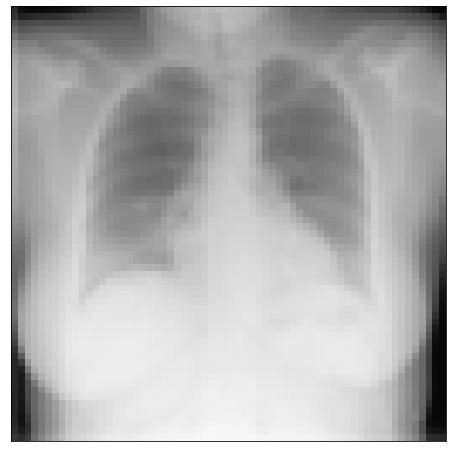

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if availabel, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosem device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)

In [17]:
discriminator = nn.Sequential(
    
    # in: 3*64*64
    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64*32*32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 * 16* 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 * 8* 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 * 4*4
    
    nn.Conv2d(512,1 , kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1*1*1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([1, 3, 64, 64])


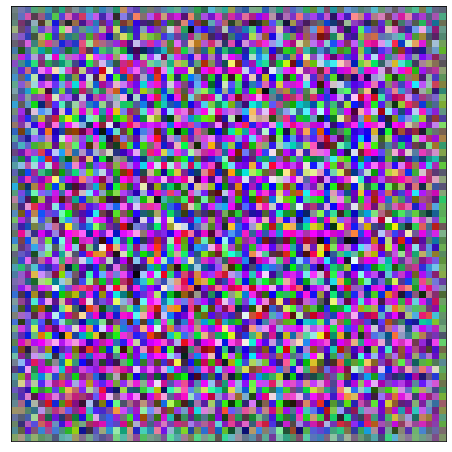

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [25]:
sample_dir = 'generated_covid'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'COVID-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [27]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving COVID-3617.png


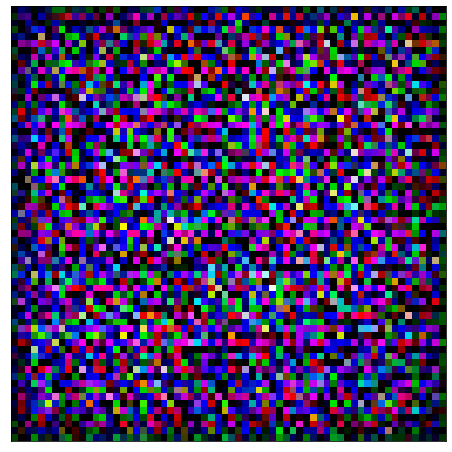

In [28]:
save_samples(3617, fixed_latent)

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    s_i = 3618
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+s_i, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 50

In [31]:
history = fit(epochs, lr)

  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 1.7393, loss_d: 1.7175, real_score: 0.1931, fake_score: 0.0705
Saving COVID-3618.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 1.5396, loss_d: 0.6188, real_score: 0.6660, fake_score: 0.1913
Saving COVID-3619.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 0.2841, loss_d: 0.5674, real_score: 0.9998, fake_score: 0.4329
Saving COVID-3620.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.3151, loss_d: 1.5641, real_score: 0.2198, fake_score: 0.0480
Saving COVID-3621.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.3816, loss_d: 0.4327, real_score: 0.7285, fake_score: 0.1095
Saving COVID-3622.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 1.2534, loss_d: 0.1820, real_score: 0.9182, fake_score: 0.0921
Saving COVID-3623.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.1658, loss_d: 0.0202, real_score: 0.9970, fake_score: 0.0170
Saving COVID-3624.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 2.2578, loss_d: 1.1785, real_score: 0.9785, fake_score: 0.6855
Saving COVID-3625.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.6117, loss_d: 0.1629, real_score: 0.9998, fake_score: 0.1502
Saving COVID-3626.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.7416, loss_d: 0.3306, real_score: 0.7404, fake_score: 0.0296
Saving COVID-3627.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.0827, loss_d: 0.0075, real_score: 0.9990, fake_score: 0.0065
Saving COVID-3628.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 7.5773, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0005
Saving COVID-3629.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.7532, loss_d: 0.0673, real_score: 0.9516, fake_score: 0.0175
Saving COVID-3630.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 1.7871, loss_d: 0.1156, real_score: 1.0000, fake_score: 0.1092
Saving COVID-3631.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 1.2313, loss_d: 0.0521, real_score: 0.9998, fake_score: 0.0505
Saving COVID-3632.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.4634, loss_d: 0.0521, real_score: 0.9501, fake_score: 0.0009
Saving COVID-3633.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.8775, loss_d: 0.0278, real_score: 1.0000, fake_score: 0.0275
Saving COVID-3634.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.3986, loss_d: 0.0043, real_score: 1.0000, fake_score: 0.0043
Saving COVID-3635.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.7068, loss_d: 0.8965, real_score: 0.4152, fake_score: 0.0174
Saving COVID-3636.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 8.1069, loss_d: 0.4051, real_score: 1.0000, fake_score: 0.3331
Saving COVID-3637.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 8.2190, loss_d: 0.0024, real_score: 0.9997, fake_score: 0.0022
Saving COVID-3638.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.0612, loss_d: 0.0380, real_score: 0.9951, fake_score: 0.0325
Saving COVID-3639.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 2.2437, loss_d: 0.5215, real_score: 0.6027, fake_score: 0.0151
Saving COVID-3640.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 2.3039, loss_d: 0.2661, real_score: 0.7682, fake_score: 0.0024
Saving COVID-3641.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.1739, loss_d: 0.0079, real_score: 0.9982, fake_score: 0.0061
Saving COVID-3642.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 5.0780, loss_d: 0.3234, real_score: 0.9998, fake_score: 0.2762
Saving COVID-3643.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.1825, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving COVID-3644.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 7.1747, loss_d: 0.0535, real_score: 0.9997, fake_score: 0.0518
Saving COVID-3645.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 8.3408, loss_d: 0.0672, real_score: 0.9647, fake_score: 0.0308
Saving COVID-3646.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 10.7984, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving COVID-3647.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.9868, loss_d: 0.0063, real_score: 1.0000, fake_score: 0.0063
Saving COVID-3648.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 4.1922, loss_d: 0.0660, real_score: 1.0000, fake_score: 0.0639
Saving COVID-3649.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.5688, loss_d: 0.0715, real_score: 1.0000, fake_score: 0.0690
Saving COVID-3650.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.5665, loss_d: 0.0250, real_score: 1.0000, fake_score: 0.0247
Saving COVID-3651.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.0416, loss_d: 0.1163, real_score: 1.0000, fake_score: 0.1098
Saving COVID-3652.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 1.6767, loss_d: 0.0403, real_score: 1.0000, fake_score: 0.0395
Saving COVID-3653.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.0268, loss_d: 0.0369, real_score: 1.0000, fake_score: 0.0362
Saving COVID-3654.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 12.2302, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003
Saving COVID-3655.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.0540, loss_d: 0.0246, real_score: 1.0000, fake_score: 0.0243
Saving COVID-3656.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.7864, loss_d: 0.1276, real_score: 0.9999, fake_score: 0.1198
Saving COVID-3657.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.4101, loss_d: 0.0653, real_score: 0.9948, fake_score: 0.0583
Saving COVID-3658.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 4.5430, loss_d: 0.0872, real_score: 0.9705, fake_score: 0.0556
Saving COVID-3659.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.0577, loss_d: 0.0242, real_score: 1.0000, fake_score: 0.0239
Saving COVID-3660.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.1255, loss_d: 0.0054, real_score: 1.0000, fake_score: 0.0054
Saving COVID-3661.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.2773, loss_d: 0.0254, real_score: 1.0000, fake_score: 0.0251
Saving COVID-3662.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.8166, loss_d: 0.0440, real_score: 1.0000, fake_score: 0.0430
Saving COVID-3663.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.9340, loss_d: 0.0360, real_score: 1.0000, fake_score: 0.0354
Saving COVID-3664.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 4.0268, loss_d: 0.0252, real_score: 0.9968, fake_score: 0.0218
Saving COVID-3665.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.8034, loss_d: 0.0141, real_score: 1.0000, fake_score: 0.0140
Saving COVID-3666.png


  0%|          | 0/3616 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.8256, loss_d: 0.0368, real_score: 1.0000, fake_score: 0.0361
Saving COVID-3667.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

In [33]:
# save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [34]:
from IPython.display import Image

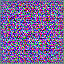

In [35]:
Image('generated_covid\\COVID-3617.png')

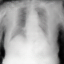

In [36]:
Image('generated_covid\\COVID-3640.png')

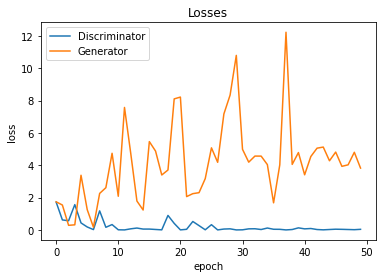

In [37]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

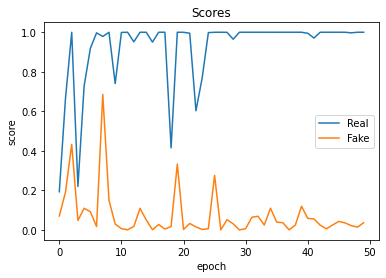

In [38]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Generating Normal Images

In [2]:
DATA_DIR = 'Datasets\\Complete_Lung_Images\\Normal'
print(os.listdir(DATA_DIR))

['Normal']


In [3]:
print(os.listdir(DATA_DIR+'/Normal')[:10])

['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-10000.png', 'Normal-10001.png', 'Normal-10002.png', 'Normal-10003.png', 'Normal-10004.png', 'Normal-10005.png']


In [4]:
image_size = 64
batch_size = 1
stats = (0.5), (0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, 
        transform = T.Compose([
            T.Resize(image_size),
#             T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
        ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1] + stats[0]

In [7]:
def show_images(images, nmax=10):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

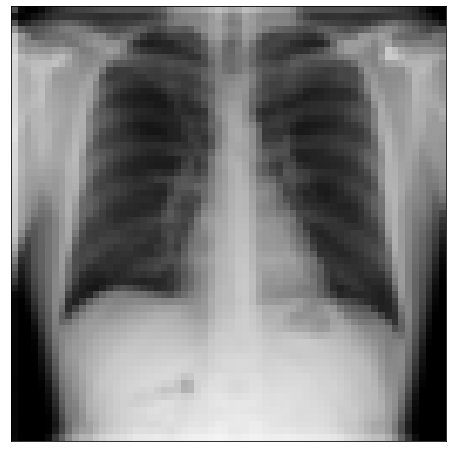

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if availabel, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosem device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    
    # in: 3*64*64
    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64*32*32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 * 16* 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 * 8* 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 * 4*4
    
    nn.Conv2d(512,1 , kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1*1*1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([1, 3, 64, 64])


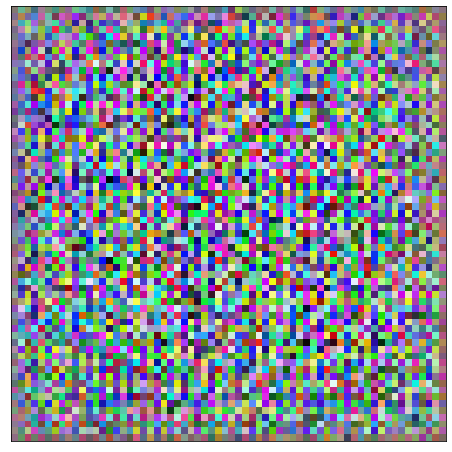

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
sample_dir = 'generated_normal'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'Normal-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [23]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving Normal-10193.png


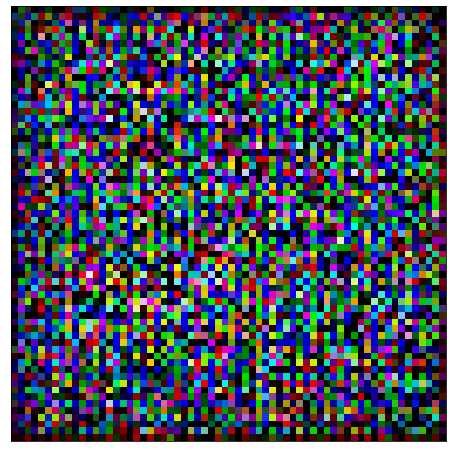

In [24]:
save_samples(10193, fixed_latent)

In [25]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    s_i = 10194
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+s_i, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
lr = 0.0002
epochs = 50

In [27]:
history = fit(epochs, lr)

  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 1.6523, loss_d: 0.0244, real_score: 0.9910, fake_score: 0.0153
Saving Normal-10194.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.2129, loss_d: 0.4097, real_score: 0.6874, fake_score: 0.0342
Saving Normal-10195.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 8.5406, loss_d: 0.5736, real_score: 0.5757, fake_score: 0.0212
Saving Normal-10196.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.7445, loss_d: 0.2968, real_score: 0.8877, fake_score: 0.1628
Saving Normal-10197.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 2.9472, loss_d: 1.0581, real_score: 0.9771, fake_score: 0.6447
Saving Normal-10198.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 1.8832, loss_d: 0.0097, real_score: 0.9962, fake_score: 0.0059
Saving Normal-10199.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.4845, loss_d: 0.0056, real_score: 0.9998, fake_score: 0.0054
Saving Normal-10200.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.3146, loss_d: 0.0776, real_score: 0.9348, fake_score: 0.0102
Saving Normal-10201.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.3641, loss_d: 0.1866, real_score: 0.9995, fake_score: 0.1698
Saving Normal-10202.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.7786, loss_d: 0.8626, real_score: 0.4258, fake_score: 0.0089
Saving Normal-10203.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 9.6034, loss_d: 0.7029, real_score: 0.9995, fake_score: 0.5046
Saving Normal-10204.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 13.2128, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving Normal-10205.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.6883, loss_d: 0.0262, real_score: 1.0000, fake_score: 0.0259
Saving Normal-10206.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 8.9073, loss_d: 0.0129, real_score: 0.9996, fake_score: 0.0124
Saving Normal-10207.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.5189, loss_d: 0.0567, real_score: 0.9998, fake_score: 0.0549
Saving Normal-10208.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.8122, loss_d: 0.0484, real_score: 0.9663, fake_score: 0.0141
Saving Normal-10209.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.2986, loss_d: 0.0251, real_score: 0.9898, fake_score: 0.0147
Saving Normal-10210.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 1.8284, loss_d: 1.1136, real_score: 0.3405, fake_score: 0.0356
Saving Normal-10211.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.8854, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0184
Saving Normal-10212.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.7745, loss_d: 0.0411, real_score: 0.9692, fake_score: 0.0098
Saving Normal-10213.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.8044, loss_d: 0.0384, real_score: 1.0000, fake_score: 0.0377
Saving Normal-10214.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.2654, loss_d: 0.0428, real_score: 0.9829, fake_score: 0.0252
Saving Normal-10215.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.3750, loss_d: 0.0318, real_score: 1.0000, fake_score: 0.0313
Saving Normal-10216.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.9535, loss_d: 0.0224, real_score: 1.0000, fake_score: 0.0222
Saving Normal-10217.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 4.1885, loss_d: 0.0273, real_score: 1.0000, fake_score: 0.0270
Saving Normal-10218.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 5.2171, loss_d: 0.0157, real_score: 1.0000, fake_score: 0.0155
Saving Normal-10219.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.5138, loss_d: 0.0289, real_score: 1.0000, fake_score: 0.0285
Saving Normal-10220.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.4499, loss_d: 0.0039, real_score: 1.0000, fake_score: 0.0039
Saving Normal-10221.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.6821, loss_d: 0.0559, real_score: 1.0000, fake_score: 0.0544
Saving Normal-10222.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.8262, loss_d: 0.0084, real_score: 1.0000, fake_score: 0.0083
Saving Normal-10223.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.4272, loss_d: 0.0314, real_score: 1.0000, fake_score: 0.0309
Saving Normal-10224.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 4.6141, loss_d: 0.0200, real_score: 1.0000, fake_score: 0.0198
Saving Normal-10225.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.4394, loss_d: 0.0194, real_score: 1.0000, fake_score: 0.0192
Saving Normal-10226.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 9.8856, loss_d: 0.0016, real_score: 1.0000, fake_score: 0.0016
Saving Normal-10227.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.3691, loss_d: 0.0025, real_score: 1.0000, fake_score: 0.0025
Saving Normal-10228.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 13.0824, loss_d: 1.1673, real_score: 1.0000, fake_score: 0.6888
Saving Normal-10229.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.5810, loss_d: 0.0096, real_score: 1.0000, fake_score: 0.0095
Saving Normal-10230.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 4.9215, loss_d: 0.0124, real_score: 1.0000, fake_score: 0.0124
Saving Normal-10231.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.0172, loss_d: 0.0130, real_score: 1.0000, fake_score: 0.0129
Saving Normal-10232.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 21.7184, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10233.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.0044, loss_d: 0.0027, real_score: 1.0000, fake_score: 0.0027
Saving Normal-10234.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.8672, loss_d: 0.0017, real_score: 1.0000, fake_score: 0.0017
Saving Normal-10235.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 7.4613, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving Normal-10236.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.9643, loss_d: 0.0031, real_score: 1.0000, fake_score: 0.0031
Saving Normal-10237.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 31.5305, loss_d: 0.7389, real_score: 1.0000, fake_score: 0.5223
Saving Normal-10238.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 10.2897, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10239.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 16.8578, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10240.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 21.9815, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10241.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 20.1416, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10242.png


  0%|          | 0/10192 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 40.4417, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Normal-10243.png


In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
# save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [30]:
from IPython.display import Image

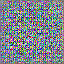

In [31]:
Image('generated_normal\\Normal-10193.png')

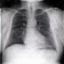

In [32]:
Image('generated_normal\\Normal-10221.png')

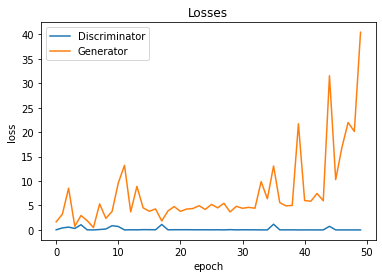

In [33]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

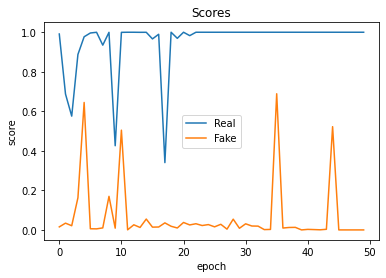

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Generatig Lung_Opacity Images

In [2]:
DATA_DIR = 'Datasets\\Complete_Lung_Images\\Lung_Opacity'
print(os.listdir(DATA_DIR))

['Lung_Opacity']


In [3]:
print(os.listdir(DATA_DIR+'/Lung_Opacity')[:10])

['Lung_Opacity-1.png', 'Lung_Opacity-10.png', 'Lung_Opacity-100.png', 'Lung_Opacity-1000.png', 'Lung_Opacity-1001.png', 'Lung_Opacity-1002.png', 'Lung_Opacity-1003.png', 'Lung_Opacity-1004.png', 'Lung_Opacity-1005.png', 'Lung_Opacity-1006.png']


In [4]:
image_size = 64
batch_size = 1
stats = (0.5), (0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, 
        transform = T.Compose([
            T.Resize(image_size),
#             T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
        ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1] + stats[0]

In [7]:
def show_images(images, nmax=10):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

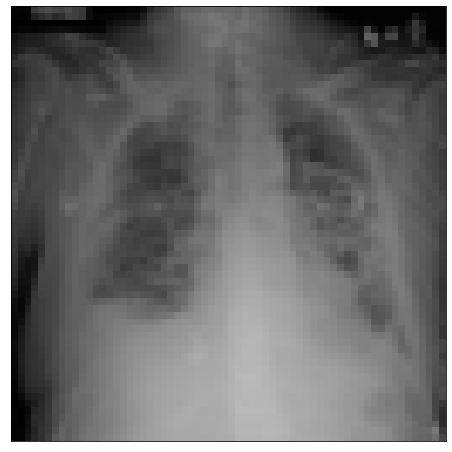

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if availabel, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosem device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    
    # in: 3*64*64
    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64*32*32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 * 16* 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 * 8* 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 * 4*4
    
    nn.Conv2d(512,1 , kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1*1*1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([1, 3, 64, 64])


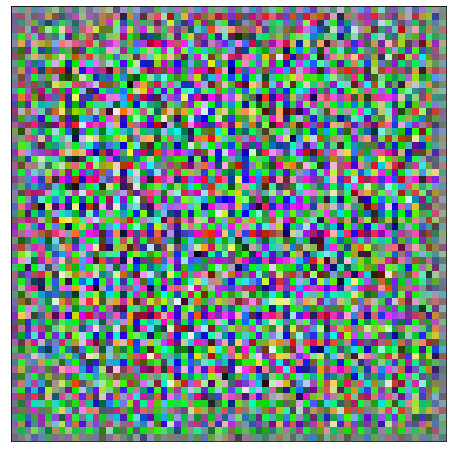

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
sample_dir = 'generated_lung_opacity'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'Lung_Opacity-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [23]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving Lung_Opacity-6013.png


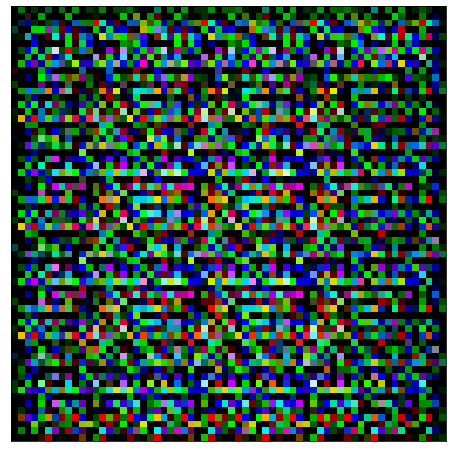

In [28]:
save_samples(6013, fixed_latent)

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    s_i=6014
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+s_i, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 50

In [31]:
history = fit(epochs, lr)

  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 4.1499, loss_d: 1.3444, real_score: 0.9999, fake_score: 0.7393
Saving Lung_Opacity-6014.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 2.0509, loss_d: 2.2500, real_score: 0.1055, fake_score: 0.0005
Saving Lung_Opacity-6015.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 5.4711, loss_d: 0.3140, real_score: 0.9893, fake_score: 0.2615
Saving Lung_Opacity-6016.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.9369, loss_d: 0.9925, real_score: 0.3754, fake_score: 0.0127
Saving Lung_Opacity-6017.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 0.4248, loss_d: 1.9975, real_score: 0.1360, fake_score: 0.0021
Saving Lung_Opacity-6018.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.7567, loss_d: 1.6154, real_score: 0.9983, fake_score: 0.8009
Saving Lung_Opacity-6019.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.0936, loss_d: 0.0673, real_score: 0.9389, fake_score: 0.0042
Saving Lung_Opacity-6020.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 3.3187, loss_d: 0.1110, real_score: 0.9590, fake_score: 0.0668
Saving Lung_Opacity-6021.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 5.6781, loss_d: 0.2357, real_score: 0.9763, fake_score: 0.1908
Saving Lung_Opacity-6022.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.7700, loss_d: 0.0666, real_score: 1.0000, fake_score: 0.0644
Saving Lung_Opacity-6023.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.6812, loss_d: 0.1698, real_score: 0.9614, fake_score: 0.1223
Saving Lung_Opacity-6024.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 2.9781, loss_d: 1.0796, real_score: 0.3399, fake_score: 0.0005
Saving Lung_Opacity-6025.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.7370, loss_d: 0.1317, real_score: 1.0000, fake_score: 0.1234
Saving Lung_Opacity-6026.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.0106, loss_d: 0.0015, real_score: 0.9986, fake_score: 0.0001
Saving Lung_Opacity-6027.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.9284, loss_d: 1.2247, real_score: 0.3049, fake_score: 0.0362
Saving Lung_Opacity-6028.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 10.4338, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving Lung_Opacity-6029.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 2.4486, loss_d: 0.2930, real_score: 0.9224, fake_score: 0.1912
Saving Lung_Opacity-6030.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 1.1652, loss_d: 5.4371, real_score: 0.9975, fake_score: 0.9956
Saving Lung_Opacity-6031.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.6321, loss_d: 0.0437, real_score: 0.9649, fake_score: 0.0080
Saving Lung_Opacity-6032.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 6.9316, loss_d: 0.1170, real_score: 1.0000, fake_score: 0.1104
Saving Lung_Opacity-6033.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 7.5547, loss_d: 0.1015, real_score: 0.9053, fake_score: 0.0021
Saving Lung_Opacity-6034.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 9.6723, loss_d: 0.0089, real_score: 0.9997, fake_score: 0.0086
Saving Lung_Opacity-6035.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 7.5497, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006
Saving Lung_Opacity-6036.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.9001, loss_d: 0.0029, real_score: 1.0000, fake_score: 0.0029
Saving Lung_Opacity-6037.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 6.0169, loss_d: 0.0069, real_score: 1.0000, fake_score: 0.0069
Saving Lung_Opacity-6038.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.2076, loss_d: 0.0217, real_score: 1.0000, fake_score: 0.0214
Saving Lung_Opacity-6039.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.8066, loss_d: 0.0174, real_score: 1.0000, fake_score: 0.0173
Saving Lung_Opacity-6040.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.1292, loss_d: 0.0415, real_score: 0.9998, fake_score: 0.0405
Saving Lung_Opacity-6041.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.1444, loss_d: 0.3261, real_score: 0.9998, fake_score: 0.2781
Saving Lung_Opacity-6042.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.6379, loss_d: 0.0276, real_score: 1.0000, fake_score: 0.0272
Saving Lung_Opacity-6043.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 1.9159, loss_d: 0.7181, real_score: 0.4930, fake_score: 0.0107
Saving Lung_Opacity-6044.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.9342, loss_d: 0.0418, real_score: 0.9718, fake_score: 0.0132
Saving Lung_Opacity-6045.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 6.6772, loss_d: 0.2490, real_score: 0.7805, fake_score: 0.0012
Saving Lung_Opacity-6046.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.7781, loss_d: 0.0180, real_score: 0.9999, fake_score: 0.0178
Saving Lung_Opacity-6047.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.1422, loss_d: 0.0057, real_score: 1.0000, fake_score: 0.0056
Saving Lung_Opacity-6048.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.2954, loss_d: 0.0124, real_score: 1.0000, fake_score: 0.0123
Saving Lung_Opacity-6049.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.7424, loss_d: 0.0211, real_score: 0.9998, fake_score: 0.0207
Saving Lung_Opacity-6050.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.9724, loss_d: 0.2838, real_score: 0.8370, fake_score: 0.1005
Saving Lung_Opacity-6051.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.7849, loss_d: 0.1014, real_score: 1.0000, fake_score: 0.0964
Saving Lung_Opacity-6052.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 10.6230, loss_d: 0.0020, real_score: 0.9998, fake_score: 0.0017
Saving Lung_Opacity-6053.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.4393, loss_d: 0.0466, real_score: 0.9995, fake_score: 0.0451
Saving Lung_Opacity-6054.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 8.3315, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004
Saving Lung_Opacity-6055.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.3715, loss_d: 0.0227, real_score: 1.0000, fake_score: 0.0225
Saving Lung_Opacity-6056.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 10.8322, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving Lung_Opacity-6057.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.8210, loss_d: 0.0133, real_score: 1.0000, fake_score: 0.0132
Saving Lung_Opacity-6058.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.2601, loss_d: 0.2516, real_score: 0.7898, fake_score: 0.0155
Saving Lung_Opacity-6059.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.9982, loss_d: 0.0322, real_score: 1.0000, fake_score: 0.0316
Saving Lung_Opacity-6060.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.9589, loss_d: 0.2194, real_score: 1.0000, fake_score: 0.1970
Saving Lung_Opacity-6061.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.7528, loss_d: 0.0104, real_score: 1.0000, fake_score: 0.0103
Saving Lung_Opacity-6062.png


  0%|          | 0/6012 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.6225, loss_d: 0.0149, real_score: 1.0000, fake_score: 0.0148
Saving Lung_Opacity-6063.png


In [32]:
losses_g, losses_d, real_scores, fake_scores = history

In [33]:
# save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [34]:
from IPython.display import Image

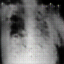

In [73]:
Image('generated_lung_opacity\\Lung_Opacity-6014.png')

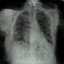

In [75]:
Image('generated_lung_opacity\\Lung_Opacity-6040.png')

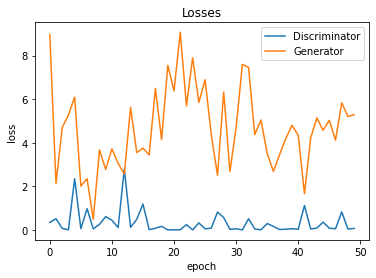

In [76]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

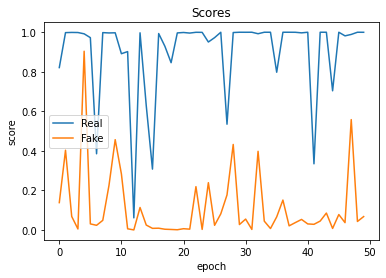

In [77]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### Generating Viral Pneumonia Images

In [39]:
DATA_DIR = 'Datasets\\Complete_Lung_Images\\Viral_Pneumonia'
print(os.listdir(DATA_DIR))

['Viral_Pneumonia']


In [40]:
print(os.listdir(DATA_DIR+'/Viral_Pneumonia')[:10])

['Viral Pneumonia-1.png', 'Viral Pneumonia-10.png', 'Viral Pneumonia-100.png', 'Viral Pneumonia-1000.png', 'Viral Pneumonia-1001.png', 'Viral Pneumonia-1002.png', 'Viral Pneumonia-1003.png', 'Viral Pneumonia-1004.png', 'Viral Pneumonia-1005.png', 'Viral Pneumonia-1006.png']


In [41]:
image_size = 64
batch_size = 1
stats = (0.5), (0.5)

In [42]:
train_ds = ImageFolder(DATA_DIR, 
        transform = T.Compose([
            T.Resize(image_size),
#             T.CenterCrop(image_size),
            T.ToTensor(),
            T.Normalize(*stats)
        ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [43]:
def denorm(img_tensors):
    return img_tensors * stats[1] + stats[0]

In [44]:
def show_images(images, nmax=10):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

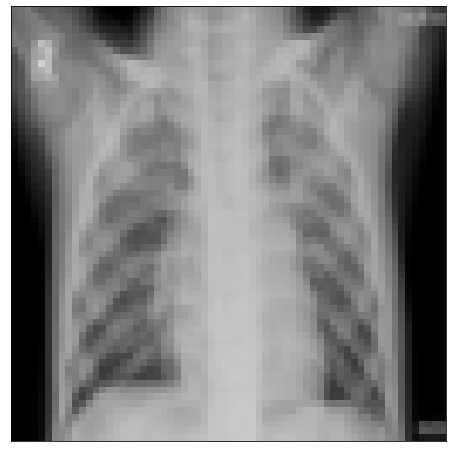

In [45]:
show_batch(train_dl)

In [46]:
def get_default_device():
    """Pick GPU if availabel, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosem device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [47]:
device = get_default_device()
device

device(type='cuda')

In [48]:
device

device(type='cuda')

In [49]:
train_dl = DeviceDataLoader(train_dl, device)

In [50]:
discriminator = nn.Sequential(
    
    # in: 3*64*64
    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64*32*32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 * 16* 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 * 8* 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 * 4*4
    
    nn.Conv2d(512,1 , kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1*1*1
    
    nn.Flatten(),
    nn.Sigmoid()

)

In [51]:
discriminator = to_device(discriminator, device)

In [52]:
latent_size = 128

In [53]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([1, 3, 64, 64])


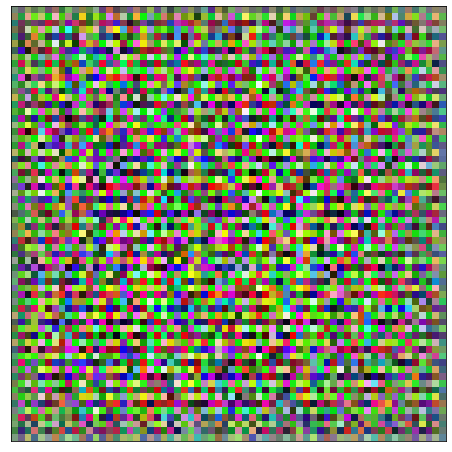

In [54]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [55]:
generator = to_device(generator, device)

In [56]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

In [57]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [58]:
sample_dir = 'generated_viral_pneumonia'
os.makedirs(sample_dir, exist_ok=True)

In [59]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'Viral Pneumonia-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [60]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)

Saving Viral Pneumonia-1346.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


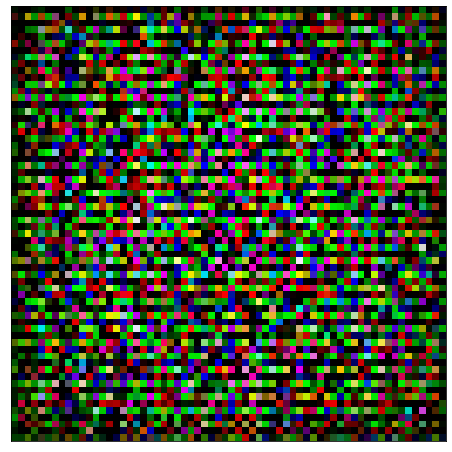

In [61]:
save_samples(1346, fixed_latent)

In [62]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    s_i = 1347
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+s_i, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [63]:
lr = 0.0002
epochs = 50

In [64]:
history = fit(epochs, lr)

  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 8.9650, loss_d: 0.3456, real_score: 0.8212, fake_score: 0.1381
Saving Viral Pneumonia-1347.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 2.1380, loss_d: 0.5180, real_score: 0.9981, fake_score: 0.4031
Saving Viral Pneumonia-1348.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.7029, loss_d: 0.0715, real_score: 0.9990, fake_score: 0.0681
Saving Viral Pneumonia-1349.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.2752, loss_d: 0.0062, real_score: 0.9986, fake_score: 0.0048
Saving Viral Pneumonia-1350.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 6.0951, loss_d: 2.3503, real_score: 0.9920, fake_score: 0.9039
Saving Viral Pneumonia-1351.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 2.0164, loss_d: 0.0587, real_score: 0.9726, fake_score: 0.0305
Saving Viral Pneumonia-1352.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 2.3528, loss_d: 0.9777, real_score: 0.3852, fake_score: 0.0234
Saving Viral Pneumonia-1353.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 0.4899, loss_d: 0.0515, real_score: 0.9981, fake_score: 0.0484
Saving Viral Pneumonia-1354.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.6722, loss_d: 0.2589, real_score: 0.9965, fake_score: 0.2254
Saving Viral Pneumonia-1355.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.7770, loss_d: 0.6126, real_score: 0.9972, fake_score: 0.4566
Saving Viral Pneumonia-1356.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.7233, loss_d: 0.4477, real_score: 0.8914, fake_score: 0.2830
Saving Viral Pneumonia-1357.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.0541, loss_d: 0.1087, real_score: 0.9021, fake_score: 0.0057
Saving Viral Pneumonia-1358.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 2.5654, loss_d: 2.7967, real_score: 0.0610, fake_score: 0.0000
Saving Viral Pneumonia-1359.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 5.6297, loss_d: 0.1233, real_score: 0.9971, fake_score: 0.1135
Saving Viral Pneumonia-1360.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.5494, loss_d: 0.4894, real_score: 0.6284, fake_score: 0.0246
Saving Viral Pneumonia-1361.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.7515, loss_d: 1.1868, real_score: 0.3076, fake_score: 0.0080
Saving Viral Pneumonia-1362.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.4448, loss_d: 0.0153, real_score: 0.9934, fake_score: 0.0087
Saving Viral Pneumonia-1363.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.4943, loss_d: 0.0771, real_score: 0.9291, fake_score: 0.0035
Saving Viral Pneumonia-1364.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.1475, loss_d: 0.1696, real_score: 0.8460, fake_score: 0.0023
Saving Viral Pneumonia-1365.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 7.5519, loss_d: 0.0043, real_score: 0.9966, fake_score: 0.0009
Saving Viral Pneumonia-1366.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 6.3802, loss_d: 0.0074, real_score: 0.9988, fake_score: 0.0061
Saving Viral Pneumonia-1367.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 9.0713, loss_d: 0.0081, real_score: 0.9958, fake_score: 0.0039
Saving Viral Pneumonia-1368.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 5.6919, loss_d: 0.2474, real_score: 0.9998, fake_score: 0.2190
Saving Viral Pneumonia-1369.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 7.8986, loss_d: 0.0032, real_score: 0.9994, fake_score: 0.0026
Saving Viral Pneumonia-1370.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.8511, loss_d: 0.3237, real_score: 0.9506, fake_score: 0.2390
Saving Viral Pneumonia-1371.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 6.8905, loss_d: 0.0513, real_score: 0.9727, fake_score: 0.0233
Saving Viral Pneumonia-1372.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.3798, loss_d: 0.0851, real_score: 0.9998, fake_score: 0.0814
Saving Viral Pneumonia-1373.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 2.5050, loss_d: 0.8208, real_score: 0.5348, fake_score: 0.1771
Saving Viral Pneumonia-1374.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 6.3284, loss_d: 0.5677, real_score: 0.9985, fake_score: 0.4323
Saving Viral Pneumonia-1375.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 2.6782, loss_d: 0.0276, real_score: 1.0000, fake_score: 0.0272
Saving Viral Pneumonia-1376.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.7032, loss_d: 0.0564, real_score: 0.9999, fake_score: 0.0548
Saving Viral Pneumonia-1377.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 7.5962, loss_d: 0.0025, real_score: 1.0000, fake_score: 0.0025
Saving Viral Pneumonia-1378.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 7.4573, loss_d: 0.5145, real_score: 0.9925, fake_score: 0.3977
Saving Viral Pneumonia-1379.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.3772, loss_d: 0.0455, real_score: 1.0000, fake_score: 0.0445
Saving Viral Pneumonia-1380.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 5.0445, loss_d: 0.0071, real_score: 1.0000, fake_score: 0.0070
Saving Viral Pneumonia-1381.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.5130, loss_d: 0.2943, real_score: 0.7977, fake_score: 0.0660
Saving Viral Pneumonia-1382.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 2.6846, loss_d: 0.1637, real_score: 1.0000, fake_score: 0.1510
Saving Viral Pneumonia-1383.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.4626, loss_d: 0.0208, real_score: 1.0000, fake_score: 0.0206
Saving Viral Pneumonia-1384.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.1982, loss_d: 0.0380, real_score: 0.9998, fake_score: 0.0371
Saving Viral Pneumonia-1385.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.8065, loss_d: 0.0576, real_score: 0.9969, fake_score: 0.0530
Saving Viral Pneumonia-1386.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.3409, loss_d: 0.0308, real_score: 1.0000, fake_score: 0.0303
Saving Viral Pneumonia-1387.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 1.6653, loss_d: 1.1241, real_score: 0.3344, fake_score: 0.0284
Saving Viral Pneumonia-1388.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.2220, loss_d: 0.0458, real_score: 1.0000, fake_score: 0.0448
Saving Viral Pneumonia-1389.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.1386, loss_d: 0.0892, real_score: 1.0000, fake_score: 0.0854
Saving Viral Pneumonia-1390.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.5706, loss_d: 0.3588, real_score: 0.7038, fake_score: 0.0075
Saving Viral Pneumonia-1391.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.0291, loss_d: 0.0810, real_score: 1.0000, fake_score: 0.0778
Saving Viral Pneumonia-1392.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.1191, loss_d: 0.0559, real_score: 0.9817, fake_score: 0.0368
Saving Viral Pneumonia-1393.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.8331, loss_d: 0.8279, real_score: 0.9889, fake_score: 0.5581
Saving Viral Pneumonia-1394.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.2068, loss_d: 0.0438, real_score: 1.0000, fake_score: 0.0428
Saving Viral Pneumonia-1395.png


  0%|          | 0/1345 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 5.2900, loss_d: 0.0701, real_score: 0.9998, fake_score: 0.0675
Saving Viral Pneumonia-1396.png


In [65]:
losses_g, losses_d, real_scores, fake_scores = history

In [66]:
# save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [67]:
from IPython.display import Image

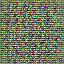

In [69]:
Image('generated_viral_pneumonia\\Viral Pneumonia-1346.png')

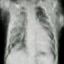

In [70]:
Image('generated_viral_pneumonia\\Viral Pneumonia-1360.png')

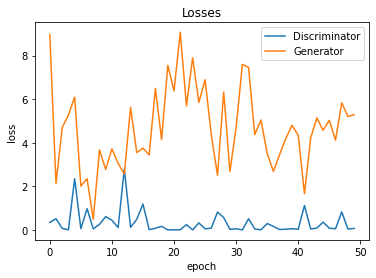

In [71]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

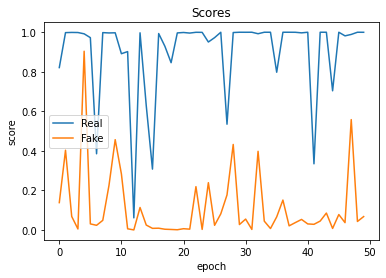

In [72]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [103]:
import os
import cv2
import time
import random
import numpy as np
import glob
import random
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### CNN

In [104]:
DIR_TRAIN = "Datasets\\Covid_Normal_Images\\train\\"
DIR_TEST = "Datasets\\Covid_Normal_Images\\test\\"

In [105]:
imgs = os.listdir(DIR_TRAIN) 
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['COVID-1.png', 'COVID-100.png', 'COVID-1004.png', 'COVID-1006.png', 'COVID-1007.png']
['COVID-10.png', 'COVID-1000.png', 'COVID-1001.png', 'COVID-1003.png', 'COVID-1005.png']


In [106]:
covid_list = [img for img in imgs if img.split("-")[0] == "COVID"]
normal_list = [img for img in imgs if img.split("-")[0] == "Normal"]

print("No of Covid Images: ",len(covid_list))
print("No of Normal Images: ",len(normal_list))

class_to_int = {"COVID" : 0, "Normal" : 1}
int_to_class = {0 : "COVID", 1 : "Normal"}

No of Covid Images:  2500
No of Normal Images:  2500


In [107]:
def get_train_transform():
    return T.Compose([
        T.Resize(64),
#         T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5),(0.5))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0.5),(0.5))
    ])

In [108]:
class Covid_Normal_Image(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((64, 64))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[image_name.split("-")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)
    

In [109]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

In [110]:
train_dataset = Covid_Normal_Image(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = Covid_Normal_Image(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())
test_dataset = Covid_Normal_Image(test_imgs, class_to_int, mode = "test", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
#     num_workers = 12,
    batch_size = 1,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
#     num_workers = 12,
    batch_size = 1,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
#     num_workers = 12,
    batch_size = 1,
    shuffle = True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


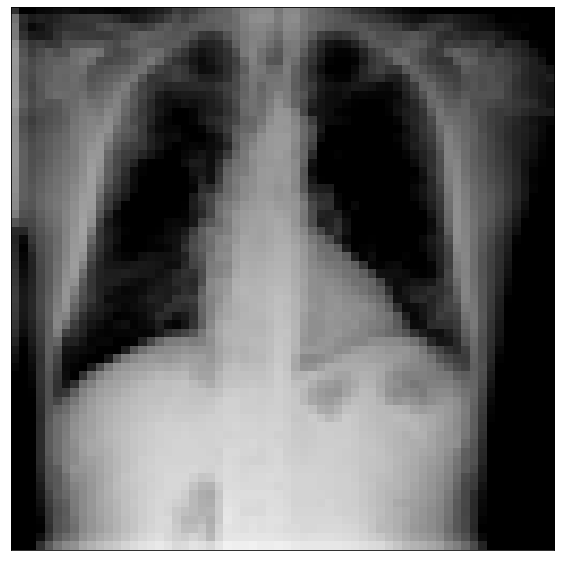

In [111]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [112]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [113]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [114]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [115]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [116]:
class Covid_Normal_CNN(nn.Module):
    
    def __init__(self):
        super(Covid_Normal_CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=8192, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        
        return out

In [117]:
model = Covid_Normal_CNN()

In [118]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# # Learning Rate Scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [119]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    


Training
Epoch 1
Loss : 0.5355
Acc : 74.3733
Time : 64.0248

Validating
Epoch 1
Loss : 0.4211
Acc : 80.72
Time : 15.0607

Training
Epoch 2
Loss : 0.4145
Acc : 81.5733
Time : 36.196

Validating
Epoch 2
Loss : 0.3875
Acc : 82.4
Time : 5.7425

Training
Epoch 3
Loss : 0.3716
Acc : 83.4133
Time : 38.3771

Validating
Epoch 3
Loss : 0.4195
Acc : 79.84
Time : 5.3549

Training
Epoch 4
Loss : 0.3364
Acc : 85.0667
Time : 36.6809

Validating
Epoch 4
Loss : 0.3709
Acc : 83.52
Time : 5.5076

Training
Epoch 5
Loss : 0.3124
Acc : 86.24
Time : 36.5497

Validating
Epoch 5
Loss : 0.3603
Acc : 84.72
Time : 5.513

Training
Epoch 6
Loss : 0.3027
Acc : 86.8267
Time : 36.4961

Validating
Epoch 6
Loss : 0.3707
Acc : 83.28
Time : 5.5197

Training
Epoch 7
Loss : 0.2789
Acc : 88.5067
Time : 36.6863

Validating
Epoch 7
Loss : 0.4293
Acc : 80.64
Time : 5.5081

Training
Epoch 8
Loss : 0.2704
Acc : 88.5067
Time : 36.8936

Validating
Epoch 8
Loss : 0.3928
Acc : 83.52
Time : 5.4901

Training
Epoch 9
Loss : 0.2602
Acc 

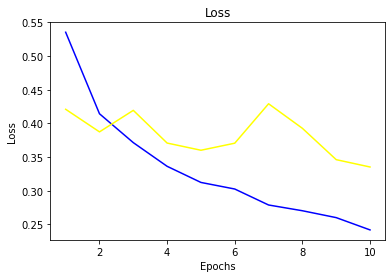

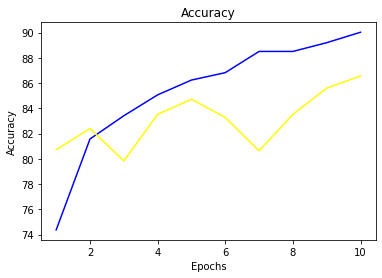

In [120]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()